In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np

C:\Users\Tom Gjonaj\AppData\Local\Temp\ipykernel_7828\2924896692.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [149]:
credits = pd.read_csv("tmdb_movie_metadata/tmdb_5000_credits.csv")
credits.rename(columns={'movie_id': 'id'}, inplace=True)
credits.drop("title", axis=1, inplace=True)
movies = pd.read_csv("tmdb_movie_metadata/tmdb_5000_movies.csv")
data = movies.merge(credits, on="id")

print(data.head)

<bound method NDFrame.head of          budget                                             genres  \
0     237000000  [{"id": 28, "name": "Action"}, {"id": 12, "nam...   
1     300000000  [{"id": 12, "name": "Adventure"}, {"id": 14, "...   
2     245000000  [{"id": 28, "name": "Action"}, {"id": 12, "nam...   
3     250000000  [{"id": 28, "name": "Action"}, {"id": 80, "nam...   
4     260000000  [{"id": 28, "name": "Action"}, {"id": 12, "nam...   
...         ...                                                ...   
4798     220000  [{"id": 28, "name": "Action"}, {"id": 80, "nam...   
4799       9000  [{"id": 35, "name": "Comedy"}, {"id": 10749, "...   
4800          0  [{"id": 35, "name": "Comedy"}, {"id": 18, "nam...   
4801          0                                                 []   
4802          0                [{"id": 99, "name": "Documentary"}]   

                                               homepage      id  \
0                           http://www.avatarmovie.com/   1999

In [150]:
print(data.columns)

Index(['budget', 'genres', 'homepage', 'id', 'keywords', 'original_language',
       'original_title', 'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'vote_average',
       'vote_count', 'cast', 'crew'],
      dtype='object')


In [151]:
print(data['cast'])

0       [{"cast_id": 242, "character": "Jake Sully", "...
1       [{"cast_id": 4, "character": "Captain Jack Spa...
2       [{"cast_id": 1, "character": "James Bond", "cr...
3       [{"cast_id": 2, "character": "Bruce Wayne / Ba...
4       [{"cast_id": 5, "character": "John Carter", "c...
                              ...                        
4798    [{"cast_id": 1, "character": "El Mariachi", "c...
4799    [{"cast_id": 1, "character": "Buzzy", "credit_...
4800    [{"cast_id": 8, "character": "Oliver O\u2019To...
4801    [{"cast_id": 3, "character": "Sam", "credit_id...
4802    [{"cast_id": 3, "character": "Herself", "credi...
Name: cast, Length: 4803, dtype: object


In [152]:
print(data.iloc[0]['genres'])

[{"id": 28, "name": "Action"}, {"id": 12, "name": "Adventure"}, {"id": 14, "name": "Fantasy"}, {"id": 878, "name": "Science Fiction"}]


In [153]:
class cast_member:
    def __init__(self, name, character, gender):
        self.name = name
        self.character = character
        self.gender = gender
        
class crew_member:
    def __init__(self, name, job, department):
        self.name = name
        self.job = job
        self.department = department

In [154]:
def convert_dict_to_1d_list(json_str):
    json_dict = json.loads(json_str) 
    return_list = []
    for item in json_dict:
        return_list.append(item['name'])
    return return_list

def convert_dict_to_class_list(json_str, class_type, dimension1, dimension2, dimension3='none'):
    json_dict = json.loads(json_str) 
    return_list = []
    for item in json_dict:
        if class_type == 'cast_members':
            gender = item.get(dimension3, None)
            tmp_person = cast_member(item[dimension1], item[dimension2], gender)
            return_list.append(tmp_person)
        elif class_type == 'crew_members':
            department = item.get(dimension3, None)
            tmp_person = crew_member(item[dimension1], item[dimension2], department)
            return_list.append(tmp_person)
    return return_list

def get_director(crew_list):
    for item in crew_list:
        if item.job == 'Director':
            return item.name
    return 'none'  

def get_crew_member_count_by_job(crew_list, job_type):
    crew_member_count = 0
    for item in crew_list:
        if job_type in item.job:
            crew_member_count += 1
    return crew_member_count  

def get_department_size(crew_list, department):
    department_size = 0
    for item in crew_list:
        if department in item.department:
            department_size += 1
    return department_size

def get_cast_number(cast_list, gender):
    cast_count = 0
    for item in cast_list:
        if str(item.gender) == str(gender):
            cast_count += 1
    return cast_count  

In [155]:
x = data.copy()

x['genres']  =  x['genres'].apply(convert_dict_to_1d_list)
x['keywords'] = x['keywords'].apply(convert_dict_to_1d_list)  
x['production_companies'] = x['production_companies'].apply(convert_dict_to_1d_list)  
x['production_countries'] = x['production_countries'].apply(convert_dict_to_1d_list)

x['country'] = x['production_countries'].apply(lambda x:x[0] if len(x)>0 else None)

x['cast'] = x['cast'].apply(convert_dict_to_class_list, 
                                                              args=('cast_members', 'name', 'character', 'gender'))   
x['crew'] = x['crew'].apply(convert_dict_to_class_list, 
                                                              args=('crew_members', 'name', 'job', 'department'))  

x['director_name'] = x['crew'].apply(get_director)   

x['dominant_genre'] = x['genres'].apply(lambda x:x[0] if len(x)>0 else 'none')  

x['title_year'] = pd.to_datetime(x['release_date']).apply(lambda x:0 if pd.isnull(x.year) else int(x.year))

x['release_week'] = pd.to_datetime(x['release_date']).apply(lambda x:0 if pd.isnull(x.week) else int(x.week))

x['cast_size'] = x['cast'].apply(lambda x:len(x) if len(x)>0 else 0)
x['crew_size'] = x['crew'].apply(lambda x:len(x) if len(x)>0 else 0)
x['number_production_companies'] = x['production_companies'].apply(lambda x:len(x) if len(x)>0 else 0)

x['director_count'] = x['crew'].apply(get_crew_member_count_by_job, args=('Director',))   
x['writer_count'] = x['crew'].apply(get_crew_member_count_by_job, args=('Screenplay',))   
x['editor_count'] = x['crew'].apply(get_crew_member_count_by_job, args=('Editor',))  

x['sound_department_size'] = x['crew'].apply(get_department_size, args=('Sound',))   
x['costume_department_size'] = x['crew'].apply(get_department_size, args=('Costume & Make-Up',)) 
x['editing_department_size'] = x['crew'].apply(get_department_size, args=('Editing',)) 
x['production_department_size'] = x['crew'].apply(get_department_size, args=('Production',)) 
x['art_department_size'] = x['crew'].apply(get_department_size, args=('Art',)) 
x['camera_department_size'] = x['crew'].apply(get_department_size, args=('Camera',)) 
x['vx_department_size'] = x['crew'].apply(get_department_size, args=('Visual Effects',)) 

x['male_cast_count'] = x['cast'].apply(get_cast_number, args = ('2'))
x['female_cast_count'] = x['cast'].apply(get_cast_number, args = ('1'))
x['unstated_gender_cast_count'] = x['cast'].apply(get_cast_number, args = ('0'))

x['spoken_languages'] = x['spoken_languages'].apply(convert_dict_to_1d_list)

# x['genres'] = x['genres'].fillna(None)
# x['keywords'] = x['keywords'].fillna(None)
# x['overview'] = x['overview'].fillna(None)
# x['country'] = x['country'].fillna(None)
# x['director_name'] = x['director_name'].fillna(None)


In [156]:
def one_hot_encoder(df, column_to_encode, control_df, control_subset_size, control_column, output_prefix):
    control_list = set(control_df.nlargest(control_subset_size, control_column)[control_column])
    
    def encode_item(item):
        if isinstance(item, list):
            encoded = {output_prefix + elem.replace(" ", ""): 1 for elem in item if elem in control_list}
        else:
            encoded = {output_prefix + item.replace(" ", ""): 1 if item in control_list else 0}
        return encoded
    
    encoded_data = df[column_to_encode].apply(lambda x: encode_item(x) if pd.notna(x) else {})
    
    encoded_df = pd.DataFrame(list(encoded_data)).fillna(0).astype(int)
    
    df = df.drop(column_to_encode, axis=1).reset_index(drop=True)
    df = pd.concat([df, encoded_df], axis=1)
    
    return df


In [157]:
from collections import defaultdict
def calculate_average_revenue(df, column):
    revenue_sum = defaultdict(float)
    count = defaultdict(int)
    
    for index, row in df.iterrows():
        entities = [row[column]] if isinstance(row[column], str) else row[column]
        if entities is None:
            continue
        for entity in entities:
            revenue_sum[entity] += row['revenue']
            count[entity] += 1
    
    # Calculate average revenue
    average_revenue = {entity: revenue_sum[entity] / count[entity] for entity in revenue_sum}
    
    return average_revenue

def one_hot_encode_top_x_by_revenue(df, columns, top_x):
    one_hot_encoded_dfs = []  # To hold one-hot encoded DataFrames for each column before concatenating
    for column in columns:
        average_revenue = calculate_average_revenue(df, column)
        
        # Sort entities based on average revenue and select top X
        top_entities = sorted(average_revenue, key=average_revenue.get, reverse=True)[:top_x]
        
        # Prepare a dict to hold the encoded data
        encoded_data = {f'{column}_is_{entity}': [] for entity in top_entities}
        
        # Fill in the encoded data
        for index, row in df.iterrows():
            entities = [row[column]] if isinstance(row[column], str) else row[column]
            if entities is None:
                for entity in top_entities:
                    encoded_data[f'{column}_is_{entity}'].append(0)
                continue
            for entity in top_entities:
                encoded_data[f'{column}_is_{entity}'].append(1 if entity in entities else 0)
        
        # Convert the encoded data to a DataFrame
        encoded_df = pd.DataFrame(encoded_data, index=df.index)
        one_hot_encoded_dfs.append(encoded_df)
    
    # Concatenate all one-hot encoded DataFrames with the original DataFrame
    df = pd.concat([df] + one_hot_encoded_dfs, axis=1)
    
    return df

In [159]:
# Save DataFrame to a CSV file
x.to_csv('moviesdataset.csv', index=False)

data_dict = x.to_dict()


In [160]:
columns_to_encode = ['director_name', 'production_companies', 'genres', 'spoken_languages', 'country', ]
x_onehot = one_hot_encode_top_x_by_revenue(x, columns_to_encode, top_x=200)

In [171]:
columns_to_drop = ['genres', 'homepage', 'id', 'keywords', 'original_language',
                   'original_title', 'overview', 'production_companies',
                   'production_countries', 'release_date', 'spoken_languages', 
                   'status', 'tagline', 'title', 'director_name', 'country',
                   'cast', 'crew', 'id', 'dominant_genre', 'vote_count', 'popularity']

x_cleaned = x_onehot.drop(columns=columns_to_drop)
x_cleaned = x_cleaned.fillna(0)

In [172]:
x_cleaned.columns[:25]

Index(['budget', 'revenue', 'runtime', 'vote_average', 'title_year',
       'release_week', 'cast_size', 'crew_size', 'number_production_companies',
       'director_count', 'writer_count', 'editor_count',
       'sound_department_size', 'costume_department_size',
       'editing_department_size', 'production_department_size',
       'art_department_size', 'camera_department_size', 'vx_department_size',
       'male_cast_count', 'female_cast_count', 'unstated_gender_cast_count',
       'director_name_is_Chris Buck', 'director_name_is_Kyle Balda',
       'director_name_is_Lee Unkrich'],
      dtype='object')

In [173]:
x_cleaned.columns[25:]

Index(['director_name_is_Joss Whedon', 'director_name_is_Chris Renaud',
       'director_name_is_James Cameron', 'director_name_is_Roger Allers',
       'director_name_is_Tim Miller', 'director_name_is_Colin Trevorrow',
       'director_name_is_Robert Stromberg', 'director_name_is_Pierre Coffin',
       'director_name_is_Dan Scanlon', 'director_name_is_David Yates',
       ...
       'country_is_Kyrgyz Republic', 'country_is_Algeria', 'country_is_Guyana',
       'country_is_Pakistan', 'country_is_Guadaloupe', 'country_is_Slovenia',
       'country_is_Afghanistan', 'country_is_Dominican Republic',
       'country_is_Cameroon', 'country_is_Kenya'],
      dtype='object', length=549)

In [174]:
Y = x_cleaned['revenue']
X = x_cleaned.drop('revenue', axis=1)

from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [175]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

gbr = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

gbr.fit(X_train, Y_train)

Y_train_pred = gbr.predict(X_train)
Y_test_pred = gbr.predict(X_test)

print("Training Set Performance:")
print("Mean Squared Error:", mean_squared_error(Y_train, Y_train_pred))
print("R^2 Score:", r2_score(Y_train, Y_train_pred))

print("\nTest Set Performance:")
print("Mean Squared Error:", mean_squared_error(Y_test, Y_test_pred))
print("R^2 Score:", r2_score(Y_test, Y_test_pred))

Training Set Performance:
Mean Squared Error: 4489004347344481.5
R^2 Score: 0.8314471025882189

Test Set Performance:
Mean Squared Error: 6969093108722917.0
R^2 Score: 0.732431999967857


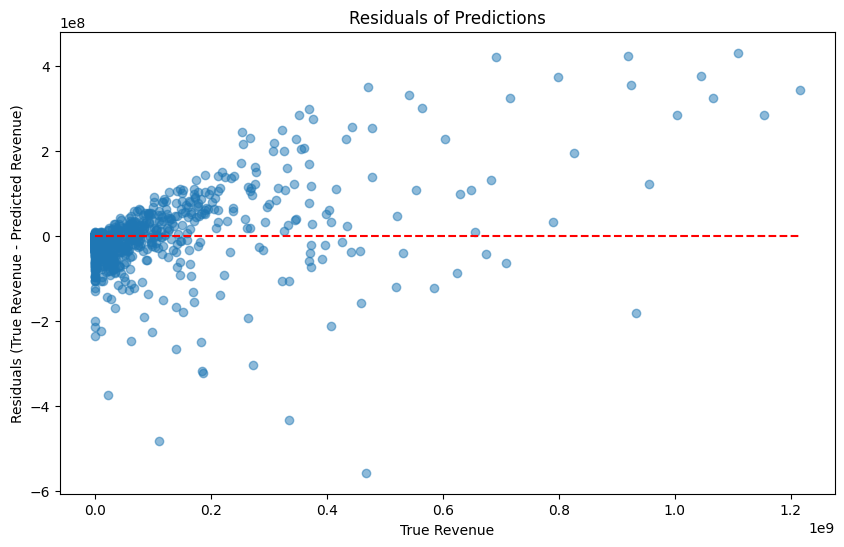

In [176]:
residuals = Y_test - Y_test_pred

plt.figure(figsize=(10, 6))
plt.scatter(Y_test, residuals, alpha=0.5)
plt.title('Residuals of Predictions')
plt.xlabel('True Revenue')
plt.ylabel('Residuals (True Revenue - Predicted Revenue)')
plt.hlines(y=0, xmin=Y_test.min(), xmax=Y_test.max(), colors='red', linestyles='--')
plt.show()


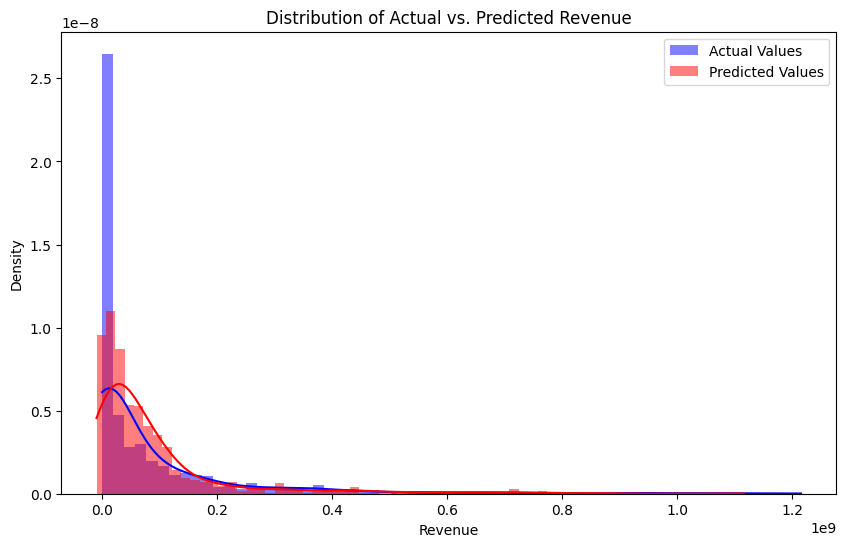

In [177]:
import seaborn as sns
plt.figure(figsize=(10, 6))

sns.histplot(Y_test, color="blue", label="Actual Values", kde=True, stat="density", linewidth=0)
sns.histplot(Y_test_pred, color="red", label="Predicted Values", kde=True, stat="density", linewidth=0)

plt.title('Distribution of Actual vs. Predicted Revenue')
plt.xlabel('Revenue')
plt.ylabel('Density')
plt.legend()
plt.show()


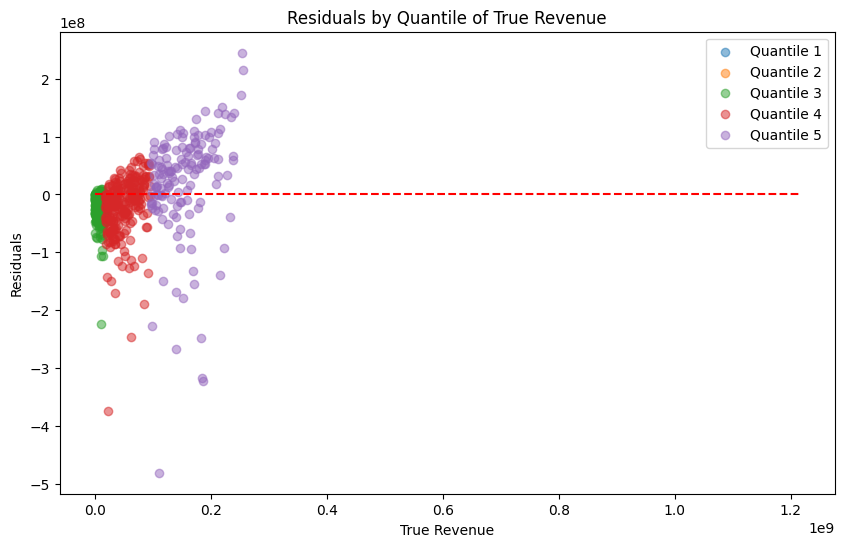

In [178]:
quantile_list = np.percentile(Y_test, [10, 25, 50, 75, 90])

residuals = Y_test - Y_test_pred

plt.figure(figsize=(10, 6))
for i, quantile in enumerate(quantile_list):
    in_quantile = (Y_test <= quantile) & (Y_test > (quantile_list[i-1] if i > 0 else 0))
    plt.scatter(Y_test[in_quantile], residuals[in_quantile], alpha=0.5, label=f'Quantile {i+1}')

plt.title('Residuals by Quantile of True Revenue')
plt.xlabel('True Revenue')
plt.ylabel('Residuals')
plt.legend()
plt.hlines(y=0, xmin=Y_test.min(), xmax=Y_test.max(), colors='red', linestyles='--')
plt.show()

Index(['director_name_is_George Lucas', 'crew_size', 'genres_is_Animation',
       'production_companies_is_Blue Sky Studios',
       'director_name_is_Peter Jackson', 'art_department_size',
       'production_companies_is_Hasbro Studios',
       'production_companies_is_Temple Hill Entertainment', 'genres_is_Drama',
       'production_companies_is_Fuji Television Network',
       'production_companies_is_Amblin Entertainment', 'male_cast_count',
       'genres_is_Adventure',
       'production_companies_is_Illumination Entertainment',
       'female_cast_count', 'cast_size', 'vx_department_size',
       'director_name_is_James Cameron', 'vote_average', 'budget'],
      dtype='object')


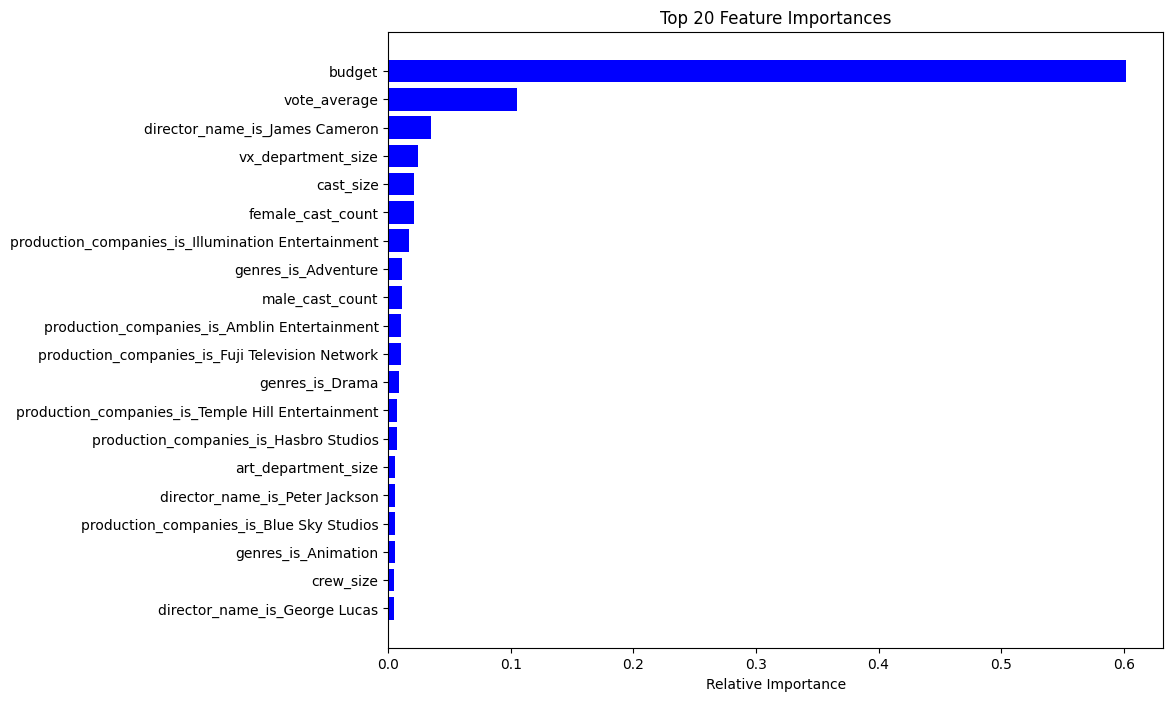

In [179]:
feature_importances = gbr.feature_importances_

indices = np.argsort(feature_importances)[-20:]

top_features = X_train.columns[indices]
print(top_features)
top_importances = feature_importances[indices]

# Plotting
plt.figure(figsize=(10, 8))
plt.title('Top 20 Feature Importances')
plt.barh(range(len(indices)), top_importances, color='b', align='center')
plt.yticks(range(len(indices)), [top_features[i] for i in range(len(indices))])
plt.xlabel('Relative Importance')
plt.show()


In [180]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(gbr, X, Y, cv=5, scoring='neg_mean_squared_error')
print("Cross-validated scores:", scores)


Cross-validated scores: [-8.50440859e+16 -6.92384305e+15 -4.39030286e+15 -2.27617324e+15
 -8.87322314e+14]
